In [8]:
%matplotlib inline
import numpy as np
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path as path

In [15]:
# functions to parse file, check data formatting and create dataframe

def parse_csv(data_file):
    """
    TODO: parse the footer:
        Total time (ms)
        Min write time (uS)
        Max write time (uS)
        Over: number of blocks which took more than 2ms to write
        Block (us): (blocks are 512 byte)
            record of any block that took more than 2ms to write
            under the form: block_ID, dur of block write in (us)
            -> correct in raw file but issue with conversion
            (missing some of the second columns)
    Also: maybe the header (but unclear where the header info come from
    since not in raw file and might be unreliable?)
    """
    blocks = {}
    in_block, block_id = False, 0
    with open(data_file, 'r') as fh:
        for i, line in enumerate(fh):
            # skip comments
            if line[0] == '%':
                continue
            # parse lines
            tokens = line.strip().split(",")
            if len(tokens) <= 3:
                # just drop the tokens for now (timestamps or footers)
                # assert len(tokens) == 1
                # n = float(tokens[0])
                # assert float(int(n)) == n
                # n = int(n)
                if in_block:
                    in_block=False
                    blocks[block_id] = lines
            else:
                if not(in_block):
                    block_id = block_id+1
                    in_block = True
                    samp_ind = 0
                    lines = []
                try:
                    assert int(tokens[0]) == samp_ind, tokens
                except:
                    print(tokens)
                samp_ind = (samp_ind + 1) % 256
                lines.append([float(e) for e in tokens[1:]])
        if in_block:
            blocks[block_id] = lines
    return blocks  # n is starting timestamp (us since cyton startup?)


def load_df(data_file, trigger_ind=17):
    blocks = parse_csv(data_file)
    dfs = {}
    for block_id in blocks:
        lines = blocks[block_id]
        df = {'channel': [], 'activity': [], 'index': []}
        for i, row in enumerate(lines):
            for ch_ind in range(16):
                df['activity'].append(row[ch_ind])
                df['channel'].append('channel {}'.format(ch_ind))
                df['index'].append(i)
            df['activity'].append(row[trigger_ind])
            df['channel'].append('trigger')
            df['index'].append(i)
        dfs[block_id] = pd.DataFrame(df)  
    return dfs


def load_raw_recordings(data_files, fs=250):
    dfs = {f: load_df(data_files[f]) for f in data_files}
    for f in dfs:
        for g in dfs[f]:
            dfs[f][g]['participant'] = f
            dfs[f][g]['block ID'] = g
    dfs = [dfs[e][f] for e in dfs for f in dfs[e]]
    raw_eeg = pd.concat(dfs)
    SCALE_FACTOR_EEG = (4500000)/24/(2**23-1) #uV/count
    #SCALE_FACTOR_AUX = 0.002 / (2**4)
    raw_eeg['activity'] = SCALE_FACTOR_EEG * raw_eeg['activity']
    raw_eeg['time'] = raw_eeg['index']/float(fs)
    return raw_eeg

def get_triggers_from_design(files):
    dat = pd.DataFrame()
    for block in range(len(files)):
        this_time = pd.DataFrame()
        this_dat = pd.io.parsers.read_csv(path.join(root, 'stims', files[block]), sep='\t')
        this_block_triggers = np.insert(np.cumsum(this_dat["dur"].values)[this_dat["cond"] != 'silence'], 0, 0)
        this_time['trigg_times'] = this_block_triggers
        this_time.insert(0, 'block ID', block)
        dat = dat.append(this_time)    
    return dat

In [3]:
# Whole session data checks and pre-processing

def plot_subset(raw_eeg, channels, time_range, stride=1,
                trigg_ch=17, act_col='activity',
                height=1, aspect=5):
    chans = ['channel {}'.format(ch) if ch != trigg_ch else 'trigger'
                 for ch in channels]
    subset = raw_eeg[([ch in chans for ch in raw_eeg['channel']]) &
                     (raw_eeg['time'] >= time_range[0]) &
                     (raw_eeg['time'] <= time_range[1]) &
                     ([ind % stride == 0 for ind in raw_eeg['index']])]
    g = sns.relplot(data=subset, col='participant', row='channel', y=act_col, x='time',
                    facet_kws={'sharey': False}, kind='line', height=height, aspect=aspect)
    g.set_axis_labels('time (s)', 'EEG activity (uV)')
    return g


def get_Butterworth_filter(cutoff, N, fs=250, plot=False):
    f_Nyq = fs/2.
    Wn = cutoff/f_Nyq
    b, a = scipy.signal.butter(N, Wn, btype='high')
    if plot:
        # plot frequency response
        w, h = scipy.signal.freqz(b, a, worN=8192)
        f = w/(2*np.pi)*f_Nyq
        plt.figure()
        plt.plot(f, 20 * np.log10(abs(h)))
        plt.xscale('log')
        plt.title('Butterworth filter frequency response')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude [dB]')
        plt.margins(0, 0.1)
        plt.grid(which='both', axis='both')
        plt.axvline(cutoff, color='green') # cutoff frequency
        # plot impulse response
        system = scipy.signal.dlti(b, a)
        t, y = scipy.signal.dimpulse(system, n=500)
        plt.figure()
        plt.step(t/float(fs), np.squeeze(y))
        plt.grid()
        plt.title('Butterworth filter impulse response')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
    return b, a


def apply_filter(b, a, df, fs=250):
    times = np.array(df['time'])
    order = np.argsort(times)
    activity = np.array(df['activity'])[order]
    # get initial filter conditions so has to avoid spurious transients
    zi = activity[0]*scipy.signal.lfilter_zi(b, a)
    filtered_act, zf = scipy.signal.lfilter(b, a, activity, zi=zi)
    filtered_act[order] = filtered_act
    df['activity'] = filtered_act
    return df


def filter_recordings(recordings, cutoff=1, N=3, fs=250, plot=True):
    # Filter with high-pass Butterworth filter with cut-off frequency at 1 Hz (filter with maximally flat passband)
    # See e.g. https://sapienlabs.org/pitfalls-of-filtering-the-eeg-signal/
    # use lfilter to make sure filtering is causal, with appropriate initial conditions to avoid initial transient
    # cutoff in Hz, (-3dB point)
    # N Butterworth filter order, could use scipy.signal.buttord to select it
    b, a = get_Butterworth_filter(cutoff=cutoff, N=N, fs=fs, plot=plot)
    filtered_recordings = recordings.groupby(['channel', 'participant']).apply(lambda df: apply_filter(b, a, df, fs=fs))
    return filtered_recordings

In [4]:
# Trigger related functions

def parse_triggers(df):
    off = True
    trigger_inds = []
    trig_df = df[df['channel'] == 'trigger']
    inds = np.array(trig_df['index'])
    order = np.argsort(inds)
    assert np.array_equal(inds[order], np.arange(len(order)))
    triggers = np.array(trig_df['activity'])[order]
    for i, val in enumerate(triggers):
        if off and val > 0:
            off = False
            trigger_inds.append(i)
        elif not(off) and val == 0:
            off = True
    return np.array(trigger_inds)


def check_triggers(df, fs=250, plot=True):
    trigger_inds = parse_triggers(df)
    trigger_ISIs = trigger_inds[1:]-trigger_inds[:-1]
    if plot:
        plt.figure()
        h = plt.hist(trigger_ISIs)
    return min(trigger_ISIs/float(fs)), max(trigger_ISIs/float(fs))

# Main

In [12]:
# params
#root = '/Users/admin/Dropbox/audmem/20191210_Marianne' #thomas
root = '/Users/duyckmf/Dropbox/audmem/20191210_Marianne'#marianne


#data_files = {'Thomas': 'OPBCI_45_test_Thomas.csv', 'Sweat': 'OPBCI_2F_test_sweat.csv'}
data_files = {'Marianne': 'SDconverted-2019-12-10_19-55-36.csv'}
data_files = {participant: path.join(root, 'EEG', data_files[participant]) for participant in data_files}
design_files = [file for file in sorted(os.listdir(path.join(root, 'stims'))) if file.endswith("_design.txt")]

# load data
raw_eeg = load_raw_recordings(data_files)
trigger_times = get_triggers_from_design(design_files)

# We only want block 2 data for this particular recording
raw_eeg = raw_eeg[raw_eeg['block ID'] == 2]
trigger_times = trigger_times[trigger_times['block ID'] == 2]

NameError: global name 'a' is not defined

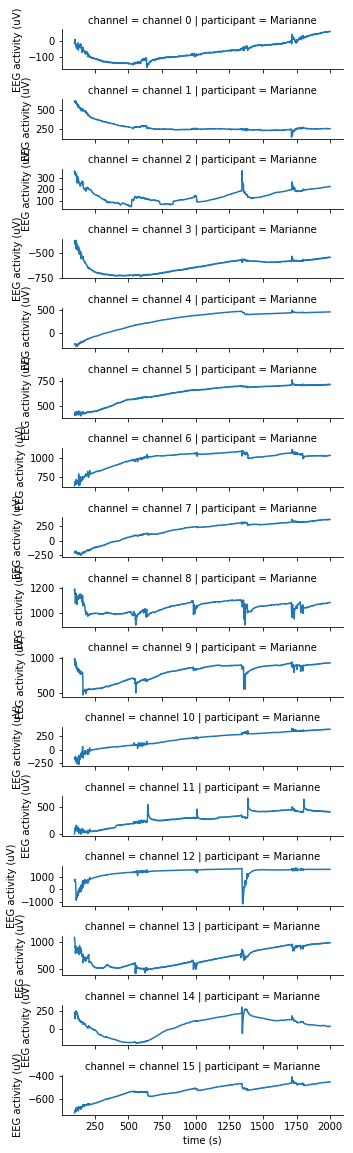

In [6]:
# look at session-wide slow drift
channels = np.arange(16)
time_range = [100, np.inf]  # in seconds

# only plot every stride sample (1 for 4 ms stride if fs=250Hz), useful to avoid too big plots
# could do low pass filtering for more principled approach
stride = 250  # every second
g = plot_subset(raw_eeg, channels, time_range, stride=stride)

/Users/admin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10


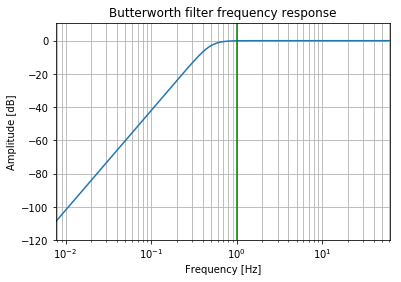

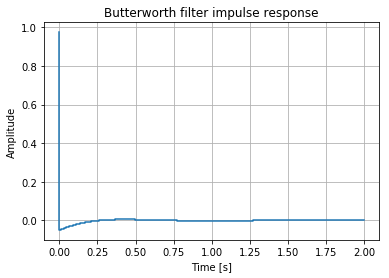

In [7]:
filtered_eeg = filter_recordings(raw_eeg)
# TODO: should we do bidirectional acausal filtering here?
# Should we do .1Hz?
# Should we do low-pass filter below 7Hz because eye closed

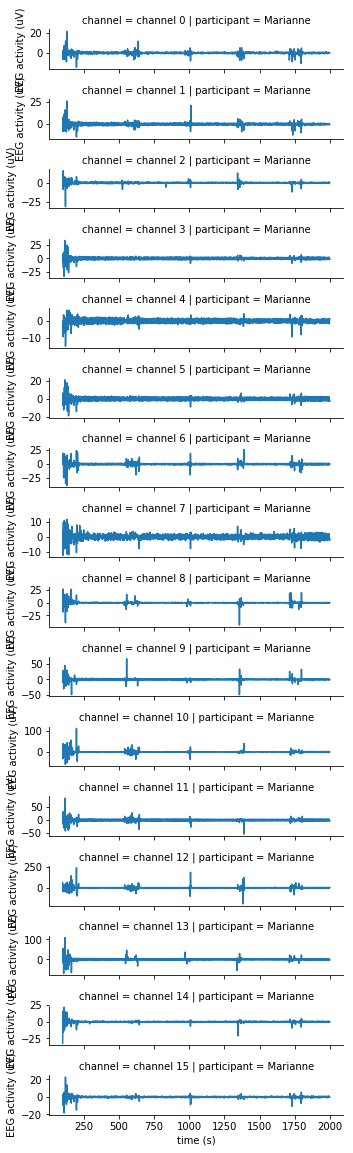

In [8]:
# look at session-wide slow drift
channels = np.arange(16)
time_range = [100, np.inf]  # in seconds

# only plot every stride sample (1 for 4 ms stride if fs=250Hz), useful to avoid too big plots
# could do low pass filtering for more principled approach
stride = 250  # every second
g = plot_subset(filtered_eeg, channels, time_range, stride=stride)

In [9]:
# get and check trigger positions to allow ERP averaging
df = raw_eeg[raw_eeg['channel'] == 'trigger']
order = np.argsort(np.array(df['time']))
trig = np.array(df['activity'])[order]

# there is a thresholding preventing downward move (at stimuli onset) to be detected
# (below 0 because of filtering of low-frequency components)
assert len(trig[trig<0] == 0)
trig_times = np.where(trig>0)[0]
cython_fs = 250.
trig_times = trig_times/cython_fs

# how to do the following in meaningful way, while taking into account
# possible clock issues?
trig_times = trig_times[np.where(np.diff(trig_times) > 4.)[0]]
block_times = np.diff(reals)[np.diff(reals) > 5.6]
for block_t in block_times:
    print(np.where(np.diff(trig_times) == block_t))
    
# 65 triggers per block? (index of last trial of block 1, 2, 3, 4)
# sil stim sil .... stim sil -> with trig at 1 during sil... -> should be 0...
trigger 2 = fin du stim 1 ... trigger 65 = fin du du stim 64 (1-index here)
2.814217 + 2.5

#TODO: use Marianne's parser to check the match between found triggers in each block
# and that block's structure

stim == 2.51s instead of 2.5s ??? or noise 2.01s - 3.01s rather than 2 - 3s
-> check wav in praat 
Alternative: tsunami and/or cython clock a bit off
    -> this seems to be the case.
-> Last check: see if the offset is really reliable (with variations
                                                     due to where cython sampling time
                                                     falls with respect to trigger position)

In [49]:
N + RN + N + RN + N + RN + N + RN + N + RN
.3 , .2 + between 2 and s

NameError: name 'N' is not defined

In [ ]:
TODOs:
    - We do not get the downward signal...
    - Is our repeated noise at the boundary of the stim (either start or end)? -> yes it is at the end.
        - We want random noise before and after it in all cases, and best would be to not have it a predictible places... 

In [ ]:
If we assume clock issue is with cython: correct our recordings accordingly?
    Can we check this hypothesis easily? 